# Machine Learning Capstone Project

## Plant Seedlings Classification: Determine the species of seedling from an image




## Step 1: Import Datasets

### Import Plant Seedlings Dataset

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train and test datasets
def load_dataset(path):
    data = load_files(path)
    seedlings_files = np.array(data['filenames'])
    seedlings_targets = np_utils.to_categorical(np.array(data['target']), 12)
    print(np.array(data['target']).shape)
    return seedlings_files, seedlings_targets

# load train and test datasets
total_files, total_targets = load_dataset('data/plant-seedlings-classification/train')

# load list of seedlings names
seedlings_names = [item[42:-1] for item in sorted(glob("data/plant-seedlings-classification/train/*/"))]


# print statistics about the datset
print('Total seedlings categories:      %d' % len(seedlings_names))
print('Total seedlings images:          %d' % len(total_files))

print('\nFollowing are the types of seedlings\n')
for _ in seedlings_names:
    print(_)

Using TensorFlow backend.


(4750,)
Total seedlings categories:      12
Total seedlings images:          4750

Following are the types of seedlings

Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
Shepherds Purse
Small-flowered Cranesbill
Sugar beet


## Step 2: Pre-process Data

### Split the Seedling Data 

In [2]:
from sklearn.model_selection import train_test_split

# split total data to get training (60%) and validation-test set (40%)
train_files, valid_test_files, train_targets, valid_test_targets = train_test_split(total_files, 
                                                                          total_targets,
                                                                          test_size = 0.4,
                                                                          random_state = 48                                                                                    
                                                                          )
# split validation-test data to get validation (20%) and test set(20%)
test_files, valid_files, test_targets, valid_targets = train_test_split(valid_test_files, 
                                                                         valid_test_targets,
                                                                         test_size = 0.5,
                                                                         random_state = 2                                                                                    
                                                                        )
# print number of training, validation and testing images
print('Seedlings images for training:   %d' % len(train_files))
print('Seedlings images for validation: %d' % len(valid_files))
print('Seedlings images for testing:    %d' % len(test_files))


Seedlings images for training:   2850
Seedlings images for validation: 950
Seedlings images for testing:    950


### Visualize the images

Image 897 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


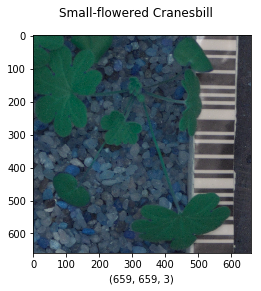

Image 2214 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


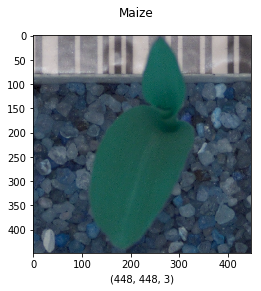

Image 2211 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


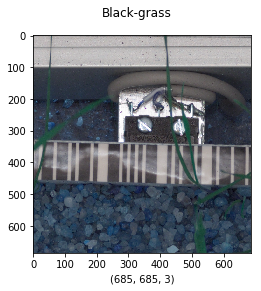

Image 368 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


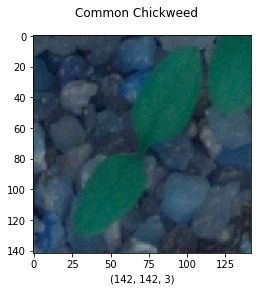

Image 2815 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


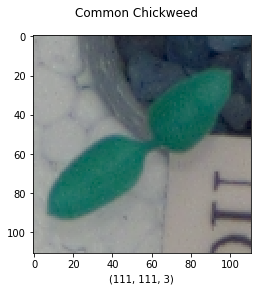

In [4]:
import cv2
import random
import matplotlib.pyplot as plt

# print random seedlings image from training data
for i in range(5):
    j = random.randint(0,2850)
    print("Image", j, train_targets[j])
    k = int(np.nonzero(train_targets[j])[0])
    img = cv2.imread(train_files[j])
    plt.suptitle(seedlings_names[k])
    plt.xlabel(img.shape)
    plt.imshow(img)
    plt.show()

### Pre-process the Seedlings Images

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Rescale the Images

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 950/950 [00:24<00:00, 38.31it/s]


### Visualize the data

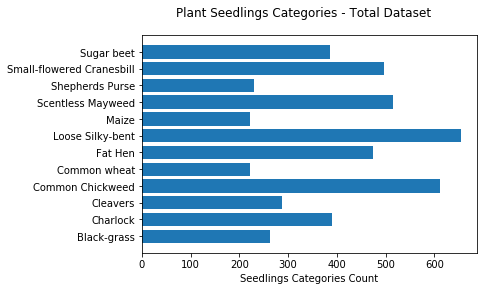

In [7]:
import matplotlib.pyplot as plt

# plot total count for all categories
count = np.sum(total_targets, axis = 0)
plt.barh(seedlings_names,count)
plt.xlabel('Seedlings Categories Count')
plt.suptitle('Plant Seedlings Categories - Total Dataset')
plt.show()

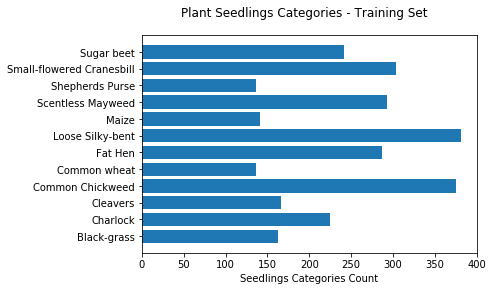

In [8]:
# plot count for training images for all categories
count = np.sum(train_targets, axis = 0)
plt.barh(seedlings_names,count)
plt.xlabel('Seedlings Categories Count')
plt.suptitle('Plant Seedlings Categories - Training Set')
plt.show()

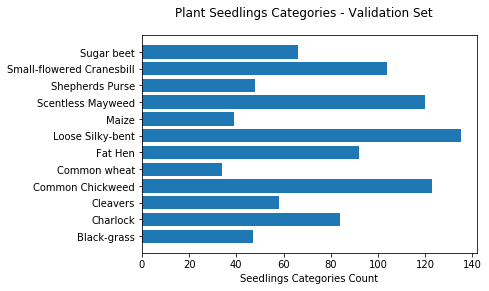

In [9]:
# plot count for validation images for all categories
count = np.sum(valid_targets, axis = 0)
plt.barh(seedlings_names,count)
plt.xlabel('Seedlings Categories Count')
plt.suptitle('Plant Seedlings Categories - Validation Set')
plt.show()

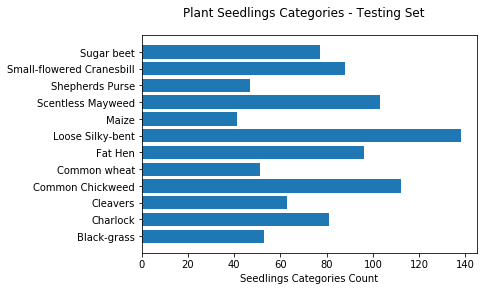

In [10]:
# plot count for testing images for all categories
count = np.sum(test_targets, axis = 0)
plt.barh(seedlings_names,count)
plt.xlabel('Seedlings Categories Count')
plt.suptitle('Plant Seedlings Categories - Testing Set')
plt.show()

### Calculate F1 Score - Custom Metrics for model compilation

Code in below cell has been taken from the link https://github.com/GeekLiB/keras/blob/master/keras/metrics.py


In [11]:
import keras.backend as K

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def f1score(y_true, y_pred):
    '''Calculates the F1 score, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

## Step 3: Create a CNN to Classify Plant Seedlings (from Scratch)

### Model Architecture

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())

model.add(Dense(12, activation='softmax'))

model.summary()
          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)        0         
__________

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

### Train the Model

In [17]:
from keras.callbacks import ModelCheckpoint

epochs = 25

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=2, save_best_only=True)

model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 2850 samples, validate on 950 samples
Epoch 1/25
 - 145s - loss: 2.4218 - f1score: 0.0000e+00 - val_loss: 2.3827 - val_f1score: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.38274, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/25
 - 146s - loss: 2.2162 - f1score: 0.0013 - val_loss: 2.0599 - val_f1score: 0.0020

Epoch 00002: val_loss improved from 2.38274 to 2.05986, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/25
 - 146s - loss: 1.9466 - f1score: 0.0224 - val_loss: 2.0521 - val_f1score: 0.0000e+00

Epoch 00003: val_loss improved from 2.05986 to 2.05212, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/25
 - 144s - loss: 1.8446 - f1score: 0.0794 - val_loss: 1.8579 - val_f1score: 0.0020

Epoch 00004: val_loss improved from 2.05212 to 1.85788, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 5/25
 - 146s - loss: 1.7789 - f1score: 0.1355 - val

### Load the model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

F1 score for the model is:  0.611578947368421


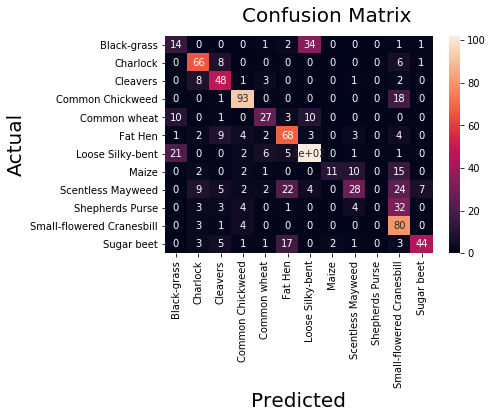

In [19]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# predict the seedling for each image in test data set
seedling_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# get the actual values
seedling_actuals = np.argmax(test_targets, axis=1)

# calculate F1 score
model_performance = f1_score(seedling_actuals, seedling_predictions, average='micro')
print('F1 score for the model is: ', model_performance)

# print confusion matrix
conf_matrix = confusion_matrix(seedling_actuals, seedling_predictions)
sns.heatmap(conf_matrix, annot=True, xticklabels=seedlings_names, yticklabels=seedlings_names)
plt.xlabel('Predicted', size=20)
plt.ylabel('Actual', size=20)
plt.suptitle('Confusion Matrix', size=20)
plt.show()

## Step 4: Create a CNN to Classify Plant Seedlings (using Transfer Learning)

## Inception V3 Model

Code reference taken from https://keras.io/applications/#inceptionv3

### Create Model Architecture

In [12]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# create a base pre-trained model
base_model=InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))

# freeze the first 200 layers
for layers in base_model.layers[:200]:
    layers.trainable=False

# add a global spatial average pooling layer 
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully connected layer
x = Dense(256, activation='relu')(x)

# add a logistic layer for 12 classes
predictions = Dense(12, activation = 'softmax')(x)

# create a model
Inception_model = Model(input = base_model.input, output = predictions)

# print summary of model
Inception_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Anaconda\Anaconda3\envs\deeplearn\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 25, 25, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 25, 25, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 25, 25, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 25, 25, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 25, 25, 64)   0           batch_normalization_20[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 12, 12, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 12, 12, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 12, 12, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 12, 12, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 12, 12, 192)  0           batch_normalization_41[0][0]     
__________

batch_normalization_74 (BatchNo (None, 12, 12, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 12, 12, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 12, 12, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 12, 12, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 12, 12, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          524544      global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           3084        dense_1[0][0]                    
Total params: 22,330,412
Trainable params: 15,331,916
Non-trainable params: 6,998,496
_______________________

### Compile the model

In [13]:
# compile the model
Inception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1score])

### Train the model

In [19]:
from keras.callbacks import ModelCheckpoint

# train the model 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=2, save_best_only=True)

Inception_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=8, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 2850 samples, validate on 950 samples
Epoch 1/8
 - 1092s - loss: 0.8673 - f1score: 0.6933 - val_loss: 2.5801 - val_f1score: 0.5379

Epoch 00001: val_loss improved from inf to 2.58010, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/8
 - 914s - loss: 0.5703 - f1score: 0.8153 - val_loss: 2.1402 - val_f1score: 0.5950

Epoch 00002: val_loss improved from 2.58010 to 2.14016, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 3/8
 - 922s - loss: 0.4088 - f1score: 0.8678 - val_loss: 0.7595 - val_f1score: 0.7924

Epoch 00003: val_loss improved from 2.14016 to 0.75947, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 4/8
 - 879s - loss: 0.2876 - f1score: 0.9016 - val_loss: 1.4212 - val_f1score: 0.7140

Epoch 00004: val_loss did not improve from 0.75947
Epoch 5/8
 - 892s - loss: 0.2565 - f1score: 0.9188 - val_loss: 1.7353 - val_f1score: 0.7058

Epoch 00005: val_loss did not improve from 0.75947
Epoch 6/8
 - 869s - loss: 0.2123 - f1score: 

### Load the model with best validation loss

In [20]:
Inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### Calculate F1 score and Confusion Matrix

F1 score for the model is:  0.8063157894736842


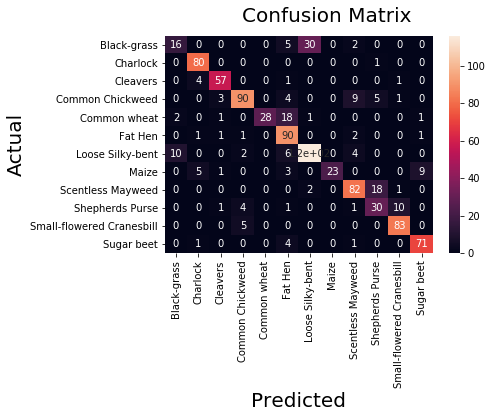

In [21]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# predict the seedling for each image in test data set
seedling_predictions = [np.argmax(Inception_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# get the actual values
seedling_actuals = np.argmax(test_targets, axis=1)

# calculate F1 score
model_performance = f1_score(seedling_actuals, seedling_predictions, average='micro')
print('F1 score for the model is: ', model_performance)

# print confusion matrix
conf_matrix = confusion_matrix(seedling_actuals, seedling_predictions)
sns.heatmap(conf_matrix, annot=True, xticklabels=seedlings_names, yticklabels=seedlings_names)
plt.xlabel('Predicted', size=20)
plt.ylabel('Actual', size=20)
plt.suptitle('Confusion Matrix', size=20)
plt.show()